In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch

from utils_.visum_utils import VisumData
from utils_ import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        # transforms.append(T.RandomRotation(degrees=45))
    return T.Compose(transforms)

In [6]:
args = {'data_path' : '../../../visum_data/train'}

dataset = VisumData(args['data_path'], modality='rgb', transforms=get_transform(train=True)) #modality='all'
dataset_val = VisumData(args['data_path'], modality='rgb', transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-100:])

In [11]:
class_train = []
class_val   = []
for each in dataset:
    class_train += each[1]['labels'].numpy().tolist()

for each in dataset_val:
    class_val += each[1]['labels'].numpy().tolist()
    
plt.hist(class_train); plt.show()
plt.hist(class_val); plt.show()

from collections import Counter
print (Counter(class_train).most_common())
print ('')
print (Counter(class_val).most_common())

# Min-Max

In [23]:
import pandas as pd
from IPython.display import display

df = pd.read_csv('../../../visum_data/train/annotation.csv', header=None)
display(df.head())

xmin = df[1].min()
xmax = df[3].max()
ymin = df[2].min()
ymax = df[4].max()

print (' - xmin (col1) : ', xmin)
print (' - xmax (col3): ', xmax)
print (' - ymin (col2): ', ymin)
print (' - ymax (col4): ', ymax)

0    1    2    3    4  5
0  RGB0000X.jpg  171  339  210  380  0
1  RGB0000X.jpg  234  340  270  379  0
2  RGB0000X.jpg  304  340  341  376  0
3  RGB0001X.jpg  152  336  201  369  0
4  RGB0001X.jpg  222  339  272  371  0

 - xmin (col1) :  120
 - xmax (col3):  392
 - ymin (col2):  291
 - ymax (col4):  456


In [57]:
import cv2
import pdb
from PIL import Image
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline


BOX_COLOR_TRUE = (0, 255, 0)
TEXT_COLOR_TRUE = (0, 0, 0)

def getannotations(csv_file, dir_images):
    annotations = {}
    with open(csv_file, 'r') as fp:
        for i, row in enumerate(fp.readlines()):
            row_tmp = row.split(',')
            image_file = str(row_tmp[0])
            x_min = float(row_tmp[1])
            y_min = float(row_tmp[2])
            x_max = float(row_tmp[3])
            y_max = float(row_tmp[4]) 
            class_ = int(row_tmp[5])
            try:
                conf = float(row_tmp[6])
            except:
                pass
            if image_file in annotations:
                annotations[image_file]['bboxes'].append([x_min, y_min, x_max, y_max])
                annotations[image_file]['category_id'].append(class_)
            else:
                image_path = os.path.join(dir_images, image_file)
                annotations[image_file] = {'image_name' : image_file,'image' : image_path, 'image_path' : image_path,'bboxes' : [[x_min, y_min, x_max, y_max]], 'category_id' : [class_]}

    return annotations

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color_box, color_text, thickness=2):
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color_box, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color_box, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_text, lineType=cv2.LINE_AA)
    return img

def visualize(annotations_true, category_id_to_name, save_dir=''):

    if (1):
        if isinstance(annotations_true['image'], str):
            img_true = cv2.imread(annotations_true['image'])
        else:
            img_true = annotations_true['image']
        for idx, bbox in enumerate(annotations_true['bboxes']):
            img_true = visualize_bbox(img_true, bbox, annotations_true['category_id'][idx], category_id_to_name, BOX_COLOR_TRUE, TEXT_COLOR_TRUE)
        
    if (1):
        f,axarr = plt.subplots(1, figsize=(10,10))
        axarr.imshow(img_true)
        axarr.set_title('Ground Truth - {0} || Size={1}'.format(annotations_true['image_name'], img_true.shape))
        axarr.set_xticks([])
        axarr.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    else:
        f,axarr = plt.subplots(1,2, figsize=(10,10))
        axarr[0].imshow(img_true)
        axarr[0].set_title('Ground Truth - {0}'.format(annotations_true['image_name']))
        axarr[0].set_xticks([])
        axarr[0].axis('off')
        pdb.set_trace()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    
    if len(save_dir):
        plt.savefig('{0}/{1}'.format(save_dir, annotations_pred['image_name'].split('.')[0] + '.png'), bbox_inches = 'tight',pad_inches = 0, format='png')
    plt.close()
    
# The coco format of a bounding box looks like [x_min, y_min, width, height], e.g. [97, 12, 150, 200].
# The pascal_voc format of a bounding box looks like [x_min, y_min, x_max, y_max], e.g. [97, 12, 247, 212].
def get_aug(aug, min_area=0., min_visibility=0.):
    return A.Compose(aug, bbox_params={'format': 'pascal_voc', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['category_id']})

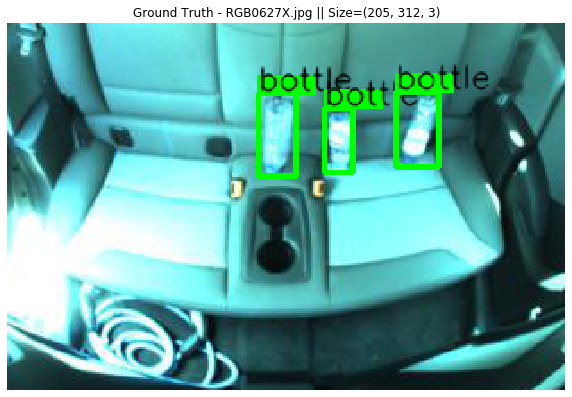

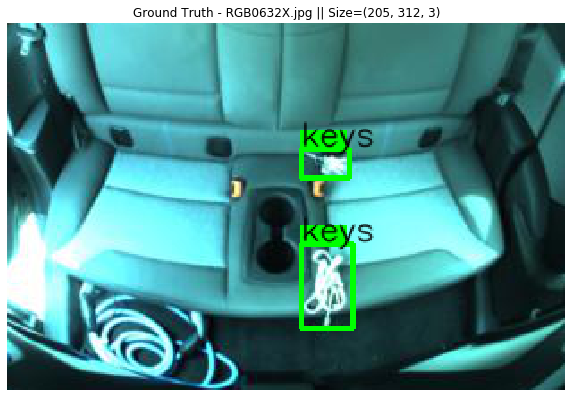

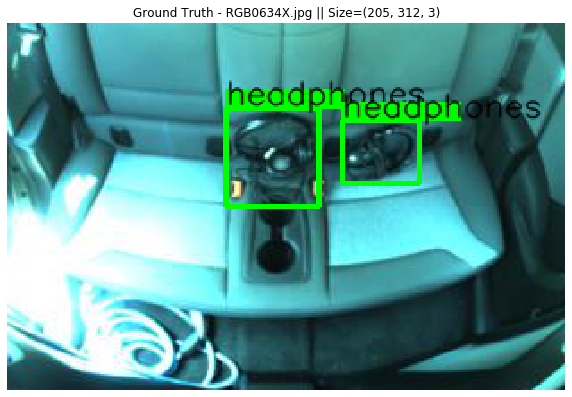

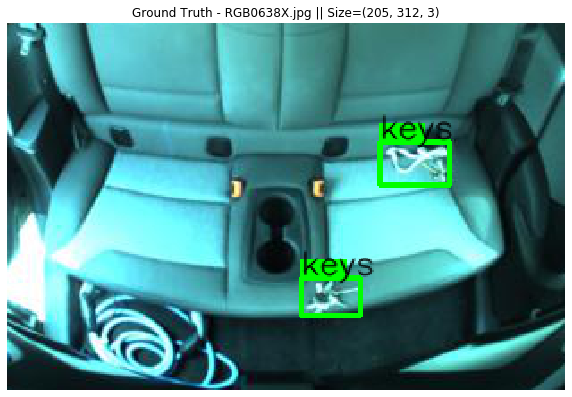

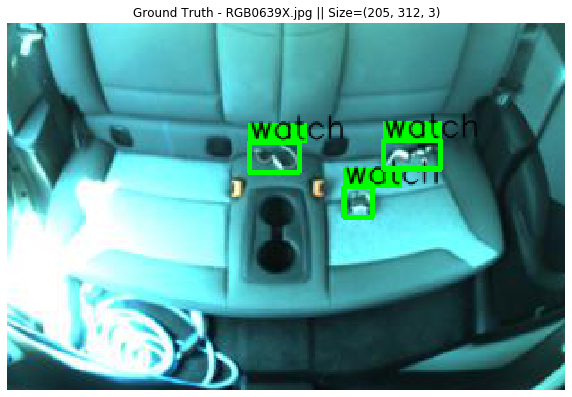

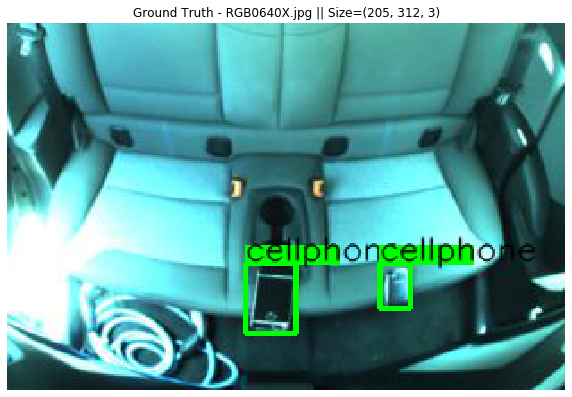

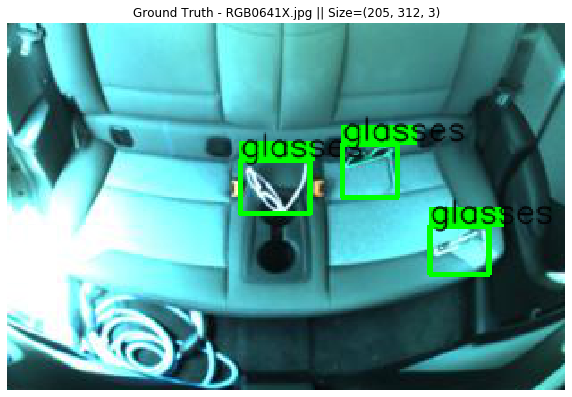

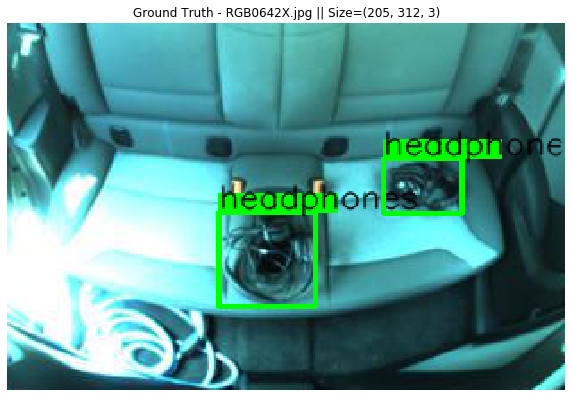

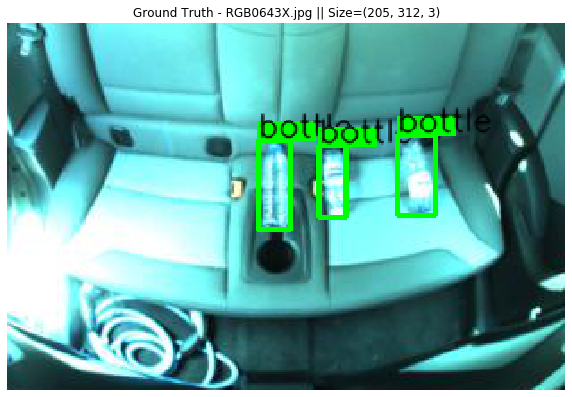

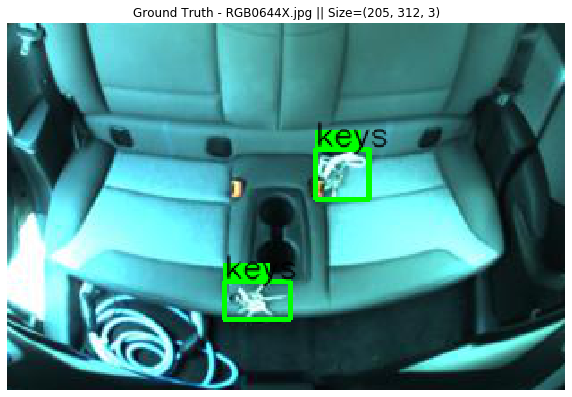

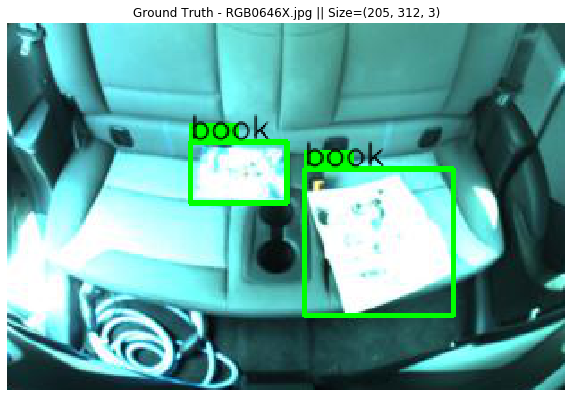

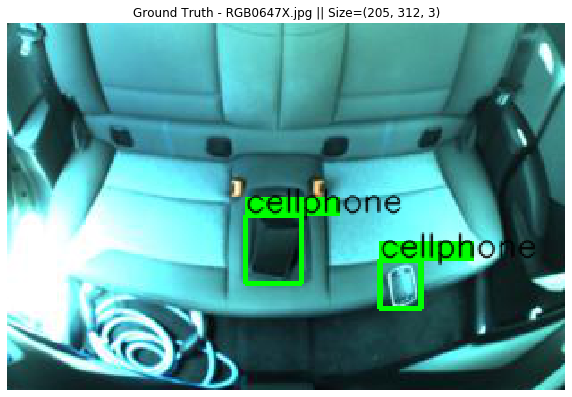

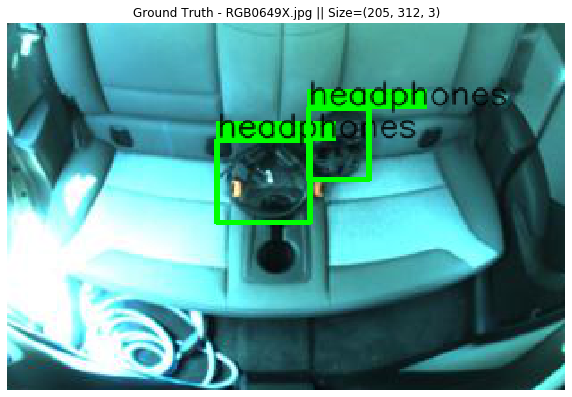

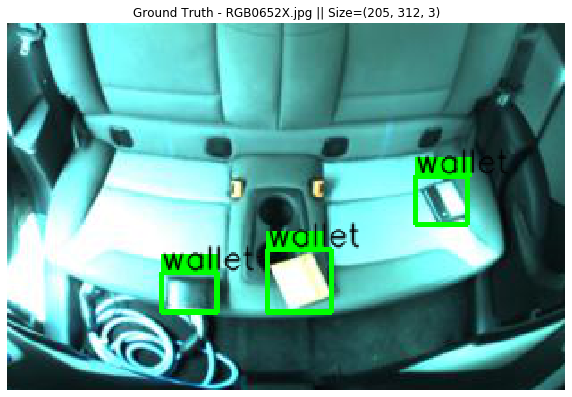

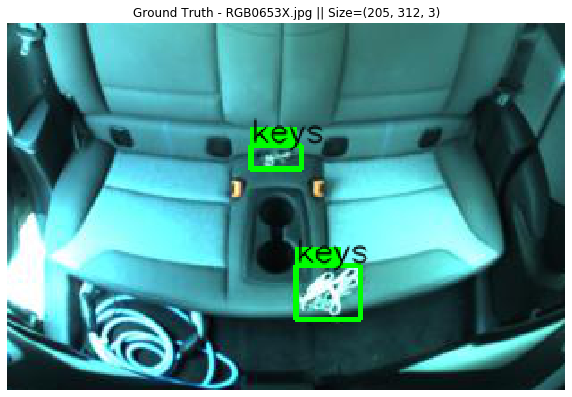

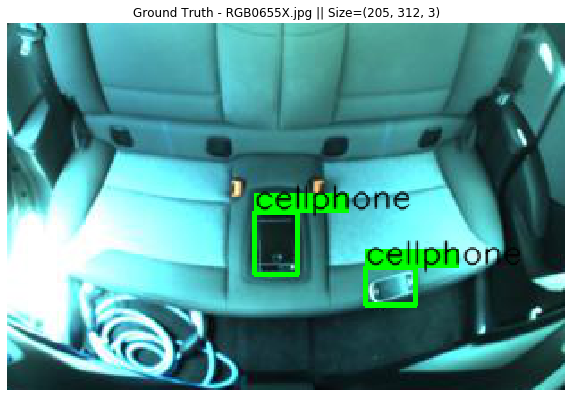

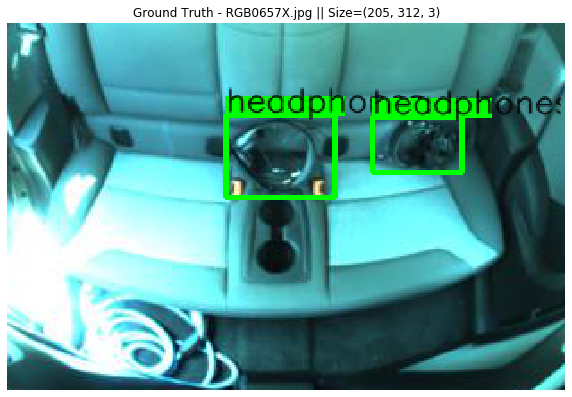

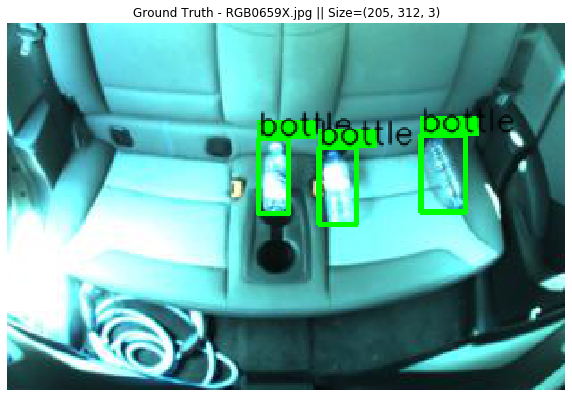

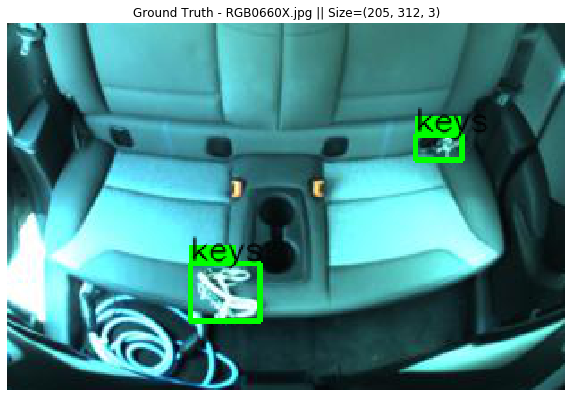

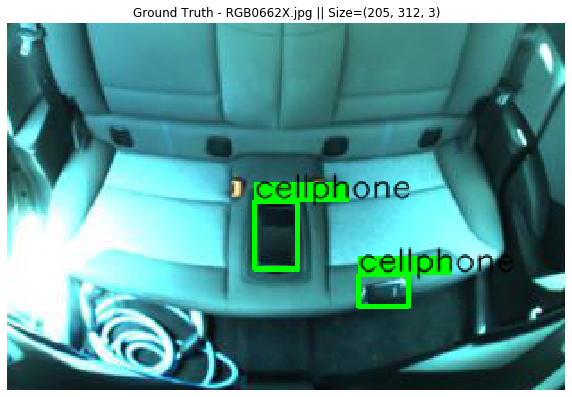

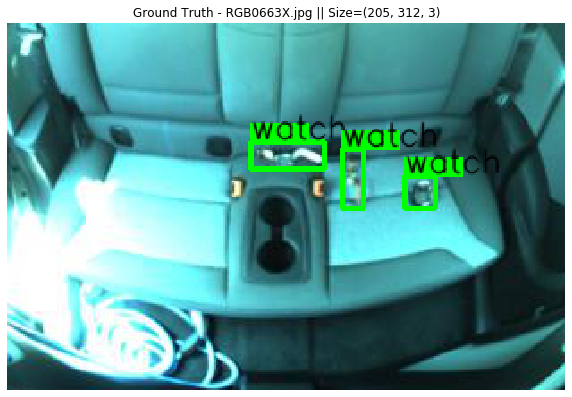

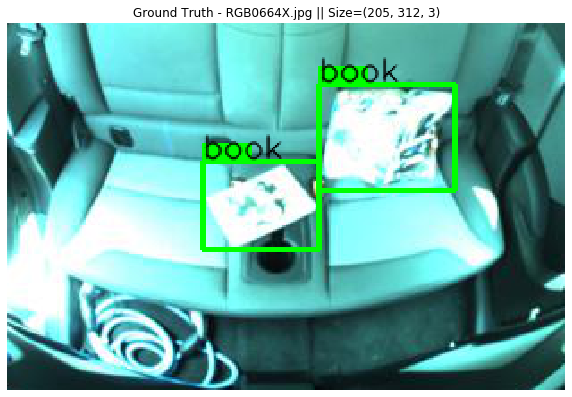

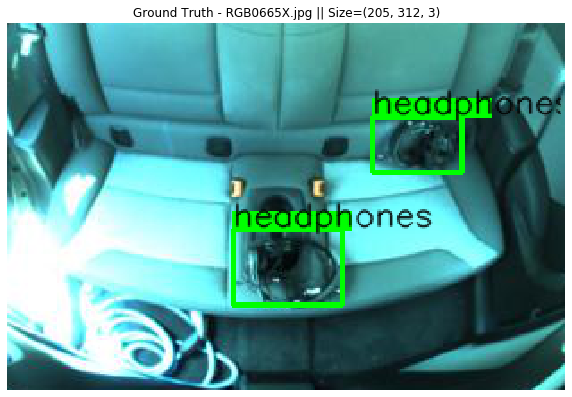

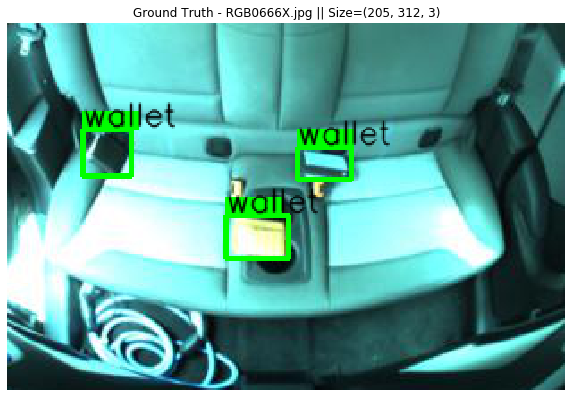

In [64]:
if (1):
    dir_images    = '../../../visum_data/train'
    csv_file_true = '../../../visum_data/train/annotation.csv'
    category_id_to_name = {
                    0: 'book', 1: 'bottle', 2: 'box', 3: 'cellphone',
                    4: 'cosmetics', 5: 'glasses', 6: 'headphones', 7: 'keys',
                    8: 'wallet', 9: 'watch', -1: 'n.a.'}
    plot_dir = ''

if (1):
    annotations_images_true = getannotations(csv_file_true, dir_images)
    for i,image in enumerate(annotations_images_true):
        if i > 500 and i < 530:
            
            annotations_image_true = annotations_images_true[image]
            if (1):
                epsilon = 20
                aug = get_aug([A.Crop(x_min=xmin-epsilon, y_min=ymin-epsilon, x_max=xmax+epsilon, y_max=ymax+epsilon, p=1.0)])
                pass

            annotations_image_true['image'] = np.array(Image.open(annotations_image_true['image']))
            augmented = aug(**annotations_image_true)

            visualize(augmented, category_id_to_name, save_dir=plot_dir)
        

In [46]:
# annotations_image_true
# Image.open(annotations_true['image_path']).crop((xmin,ymin,xmax,ymax))
import albumentations as A
A.Crop(x_min=xmin, y_min=ymin, x_max=xmax, y_max=ymax, p=1.0)

AttributeError: module 'albumentations.augmentations.transforms' has no attribute 'crop'